# Data management for database searching and result analysis

- Transforming to FASTA format
- Generating mgf processing files for easy indexing with msconvert
- Distribution plots for the target-decoy approach

In [2]:
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

merged_df = pd.read_csv('data/merged_df.txt', sep='\t')

In [3]:
only_incorrect_df = merged_df[merged_df['DENOVO'] != merged_df['updated sequence']]
print(f'Number of all incorrect annotations: {only_incorrect_df.shape[0]}')

Number of all incorrect annotations: 171600


In [9]:
def convert_to_fasta(output_path, df, column_name):
    with open(output_path, 'w') as output_file:
        for index, row in df.iterrows():
            identifier_line = f">{row['file']}|{row['scan']}|{row['charge']}\n"
            sequence_line = row[column_name] + "\n"
            
            output_file.write(identifier_line)
            output_file.write(sequence_line)
    
    return(f"FASTA file saved!")

def check_fasta_file(path, df):
    sequence_count = 0
    with open(path, 'r') as fasta_file:
        for line in fasta_file:
            if line.startswith('>'):
                sequence_count += 1
    return f'Number of annotations: {sequence_count}, matched the required value: {sequence_count == df.shape[0]}'

def mgf_processing(file_name, df):
    df1 = df[['file', 'scan']]
    df1.loc[:, 'scan'] = df1['scan'] - 1
    df1.loc[:, 'file'] = df1['file'].str.replace('/hdd/data', '', regex=False)

    df1.to_csv(f'mgf-processing/{file_name}.tsv', index=False, sep='\t')
    return 'Mgf-processing file saved!'

def plot_distribution(target_df, decoy_df, nbins, title):
    plt.figure(figsize=(8, 6))

    min_score = min(target_df['xcorr score'].min(), decoy_df['xcorr score'].min())
    max_score = max(target_df['xcorr score'].max(), decoy_df['xcorr score'].max())
    bin_edges = np.linspace(min_score, max_score, nbins + 1)

    sns.histplot(target_df['xcorr score'], bins=bin_edges, color='seagreen', label='Target Score distribution', stat='count')
    sns.histplot(decoy_df['xcorr score'], bins=bin_edges, color='red', label='Decoy distribution', stat='count')

    plt.xlabel('XCorr score', fontsize=12)
    plt.ylabel('Counts', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')

    plt.legend(frameon=True, fontsize=12, loc='upper right')

    plt.grid(True, alpha=0.5)
    plt.show()

FASTA file saved!
Number of annotations: 171600, matched the required value: True
Mgf-processing file saved!


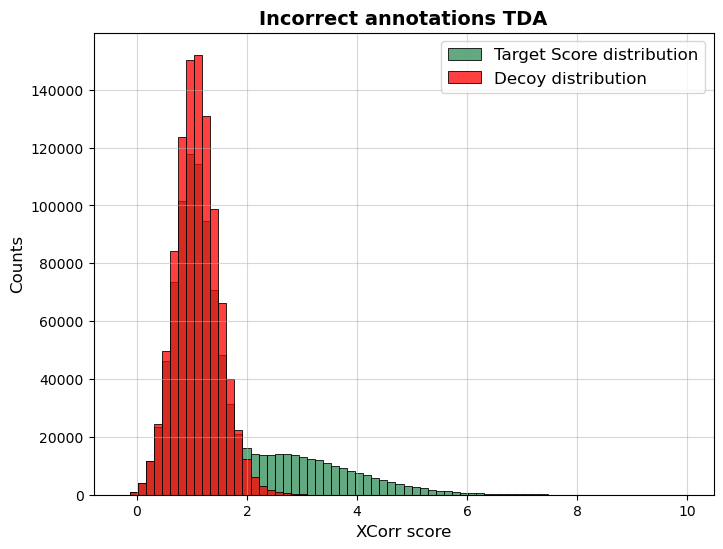

In [10]:
'''
1st search:
all incorrect annotations regardless other conditions
'''
output_path_fasta = 'fasta/all_incorrect_pepnet.fasta'
output_path_tsv = 'all_incorrect_mgf_processing'

print(convert_to_fasta(output_path_fasta, only_incorrect_df, 'DENOVO'))
print(check_fasta_file(output_path_fasta, only_incorrect_df))
print(mgf_processing(output_path_tsv, only_incorrect_df))

# only incorrect annotations search
title0 = 'Incorrect annotations TDA'

target_df0 = pd.read_csv('search-results/wrong-pepnet-peptides.tide-search.target.txt', sep='\t')
decoy_df0 = pd.read_csv('search-results/wrong-pepnet-peptides.tide-search.decoy.txt', sep='\t')
plot_distribution(target_df0, decoy_df0, 70, title0)

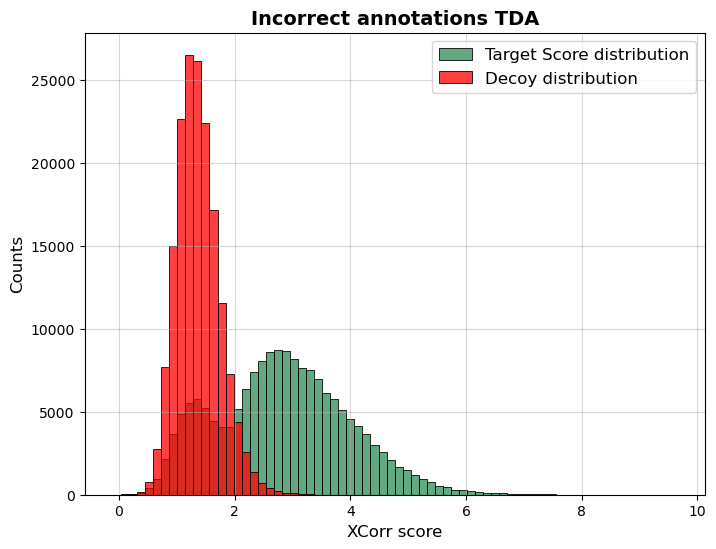

In [11]:
# incorrect annotations & mgf search
title = 'Incorrect annotations TDA'

target_df = pd.read_csv('search-results/incorrect-annotations.target.txt', sep='\t')
decoy_df = pd.read_csv('search-results/incorrect-annotations.decoy.txt', sep='\t')
plot_distribution(target_df, decoy_df, 70, title)

102636
FASTA file saved!
Number of annotations: 102636, matched the required value: True
Mgf-processing file saved!


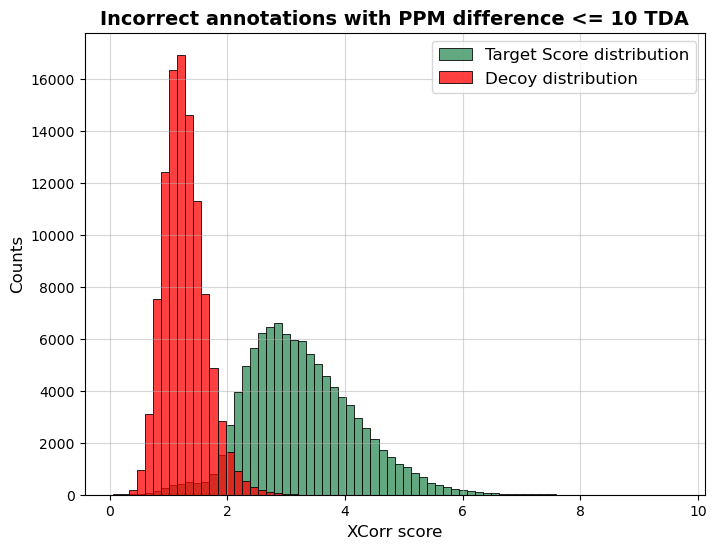

In [12]:
'''
2nd search:
incorrect annotations with ppm difference <= 10
'''
only_incorrect_df_ppm = only_incorrect_df[abs(only_incorrect_df['PPM Difference']) <= 10]
print(only_incorrect_df_ppm.shape[0])
output_path_fasta2 = 'fasta/incorrect_ppm_le10_pepnet.fasta'
output_path_tsv2 = 'incorrect_ppm_le10_mgf_processing'

print(convert_to_fasta(output_path_fasta2, only_incorrect_df_ppm, 'DENOVO'))
print(check_fasta_file(output_path_fasta2, only_incorrect_df_ppm))
print(mgf_processing(output_path_tsv2, only_incorrect_df_ppm))

title2 = 'Incorrect annotations with PPM difference <= 10 TDA'

target_df2 = pd.read_csv('search-results/incorrect-annotations_ppm_le10.target.txt', sep='\t')
decoy_df2 = pd.read_csv('search-results/incorrect-annotations_ppm_le10.decoy.txt', sep='\t')
plot_distribution(target_df2, decoy_df2, 70, title2)

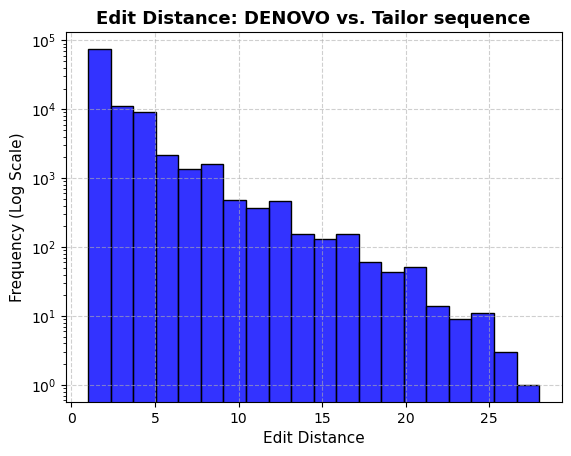

In [13]:
'''
edit distance of denovo and tailor
'''

sns.histplot(only_incorrect_df_ppm['edit distance pepnet-tailor'], bins=20, color='blue', edgecolor='black', alpha=0.8)
plt.yscale('log')
plt.title('Edit Distance: DENOVO vs. Tailor sequence', fontsize=13, fontweight='bold')
plt.xlabel('Edit Distance', fontsize=11)
plt.ylabel('Frequency (Log Scale)', fontsize=11)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

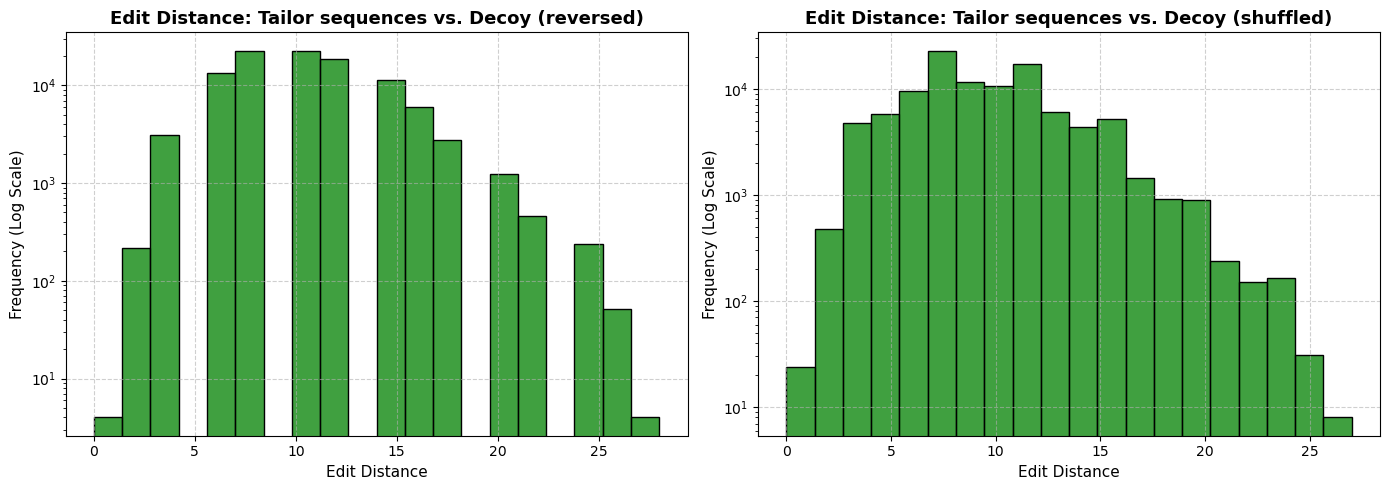

In [14]:
'''
comparing distributions with different decoy approaches
'''
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# first subplot - tailor vs reversed decoy
sns.histplot(only_incorrect_df_ppm['edit distance tailor-decoy'], bins=20, color='green', edgecolor='black', ax=ax1)
ax1.set_yscale('log')
ax1.set_title('Edit Distance: Tailor sequences vs. Decoy (reversed)', fontsize=13, fontweight='bold')
ax1.set_xlabel('Edit Distance', fontsize=11)
ax1.set_ylabel('Frequency (Log Scale)', fontsize=11)
ax1.grid(True, linestyle='--', alpha=0.6)

# second subplot - tailor vs shuffled decoy
sns.histplot(only_incorrect_df_ppm['edit distance tailor-decoy-shuffled'], bins=20, color='green', edgecolor='black', ax=ax2)
ax2.set_yscale('log')
ax2.set_title('Edit Distance: Tailor sequences vs. Decoy (shuffled)', fontsize=13, fontweight='bold')
ax2.set_xlabel('Edit Distance', fontsize=11)
ax2.set_ylabel('Frequency (Log Scale)', fontsize=11)
ax2.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

478
FASTA file saved!
Number of annotations: 478, matched the required value: True
Mgf-processing file saved!


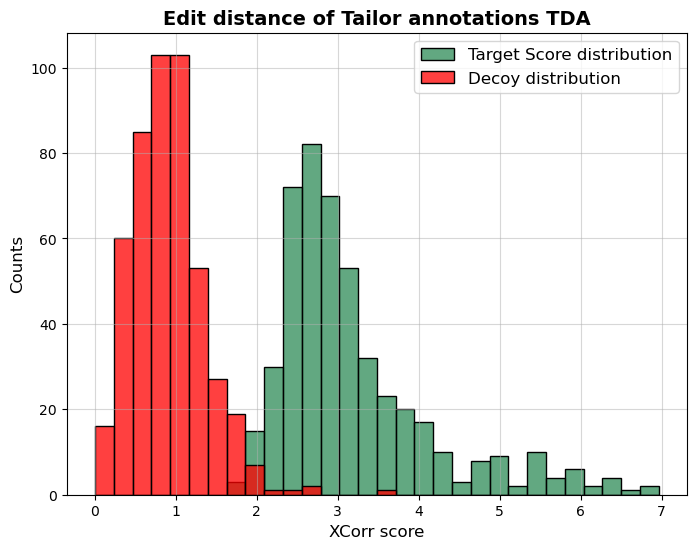

In [23]:
'''
3rd search:
tailor (considered correct) sequences,
edit distance pepnet-tailor more or equal to 15
'''
incorrect_ppm_edit_dist = only_incorrect_df_ppm[abs(only_incorrect_df_ppm['edit distance pepnet-tailor']) >= 15]
print(incorrect_ppm_edit_dist.shape[0])
output_path_fasta3 = 'fasta/incorrect_ppm_edit_tailor.fasta'
output_path_tsv3 = 'incorrect_ppm_edit_mgf_processing'

print(convert_to_fasta(output_path_fasta3, incorrect_ppm_edit_dist, 'updated sequence'))
print(check_fasta_file(output_path_fasta3, incorrect_ppm_edit_dist))
print(mgf_processing(output_path_tsv3, incorrect_ppm_edit_dist))

title3 = 'Edit distance of Tailor annotations TDA'
target_df3 = pd.read_csv('search-results/tailor.tide-search-edit.target.txt', sep='\t')
decoy_df3 = pd.read_csv('search-results/tailor.tide-search-edit.decoy.txt', sep='\t')

plot_distribution(target_df3, decoy_df3, 30, title3)

FASTA file saved!
Number of annotations: 478, matched the required value: True


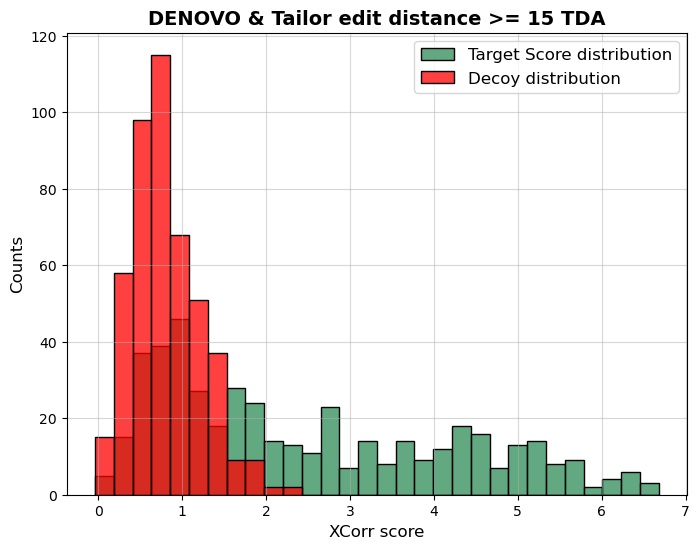

In [24]:
'''
4th search:
pepnet (DENOVO) sequences,
edit distance pepnet-tailor more or equal to 15
'''

output_path_fasta4 = 'fasta/incorrect_ppm.pepnet.edit-me15.fasta'

print(convert_to_fasta(output_path_fasta4, incorrect_ppm_edit_dist, 'DENOVO'))
print(check_fasta_file(output_path_fasta4, incorrect_ppm_edit_dist))


title4 = 'DENOVO & Tailor edit distance >= 15 TDA'
target_df4 = pd.read_csv('search-results/pepnet-edit_distance_me15.tide-search.target.txt', sep='\t')
decoy_df4 = pd.read_csv('search-results/pepnet-edit_distance_me15.tide-search.decoy.txt', sep='\t')

plot_distribution(target_df4, decoy_df4, 30, title4)

FASTA file saved!
Number of annotations: 102636, matched the required value: True
FASTA file saved!
Number of annotations: 102636, matched the required value: True
FASTA file saved!
Number of annotations: 102636, matched the required value: True


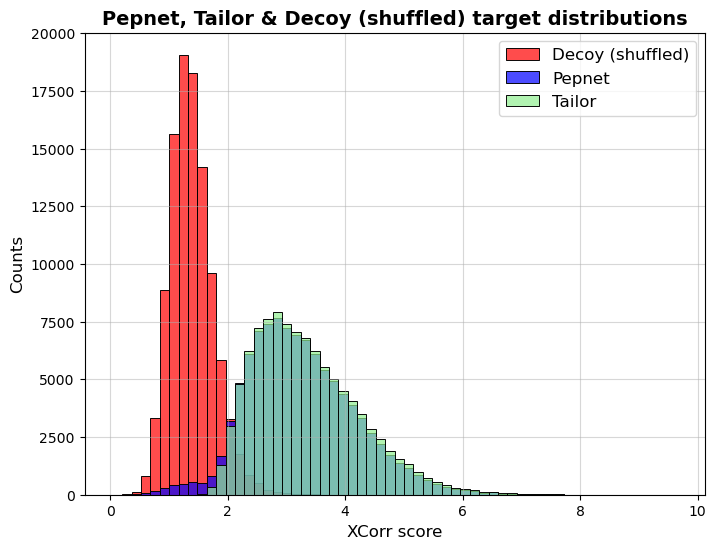

In [22]:
'''
5, 6, 7 searches:
pepnet, tailor and decoy (shuffled) target distributions
'''

output_path_fasta5 = 'fasta/incorrect_ppm.pepnet.fasta'
output_path_fasta6 = 'fasta/incorrect_ppm.tailor.fasta'
output_path_fasta7 = 'fasta/incorrect_ppm.decoy.fasta'

print(convert_to_fasta(output_path_fasta5, only_incorrect_df_ppm, 'DENOVO'))
print(check_fasta_file(output_path_fasta5, only_incorrect_df_ppm))

print(convert_to_fasta(output_path_fasta6, only_incorrect_df_ppm, 'updated sequence'))
print(check_fasta_file(output_path_fasta6, only_incorrect_df_ppm))

print(convert_to_fasta(output_path_fasta7, only_incorrect_df_ppm, 'decoy (shuffled)'))
print(check_fasta_file(output_path_fasta7, only_incorrect_df_ppm))

target_df_decoy = pd.read_csv('search-results/decoy.tide-search.target.txt', sep='\t')
target_df_pepnet = pd.read_csv('search-results/pepnet.tide-search.target.txt', sep='\t')
target_df_tailor = pd.read_csv('search-results/tailor.tide-search.target.txt', sep='\t')

def plot_multiple_distributions(dfs, labels, colors, nbins, title, alpha=0.5):
    plt.figure(figsize=(8, 6))

    min_score = min([df['xcorr score'].min() for df in dfs])
    max_score = max([df['xcorr score'].max() for df in dfs])
    bin_edges = np.linspace(min_score, max_score, nbins + 1)

    for df, label, color in zip(dfs, labels, colors):
        sns.histplot(df['xcorr score'], bins=bin_edges, color=color, label=label, stat='count', alpha=alpha)

    plt.xlabel('XCorr score', fontsize=12)
    plt.ylabel('Counts', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.legend(frameon=True, fontsize=12, loc='upper right')
    plt.grid(True, alpha=0.5)
    plt.show()

plot_multiple_distributions(
    dfs=[target_df_decoy, target_df_pepnet, target_df_tailor],
    labels=['Decoy (shuffled)', 'Pepnet', 'Tailor'],
    colors=['red', 'blue', 'lightgreen'],
    nbins=60,
    title='Pepnet, Tailor & Decoy (shuffled) target distributions',
    alpha=0.7
)